Imports

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

Data import

In [73]:
train = pd.read_csv("data/training.csv")
test = pd.read_csv("data/test.csv")




In [74]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

    # f1_scores = cross_val_score(XGBRegressor(), X, y, scoring="f1", cv=5)
    # f1_scores = pd.Series(f1_scores, name="F1 Scores")

Exploring dataSet

In [75]:

# train.select_dtypes(["object"]).nunique()
train.head(5)
# test.select_dtypes(["object"]).nunique()
# test.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [76]:
train.nunique()
# test.nunique()

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
CurrencyCode                1
CountryCode                 1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1676
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
FraudResult                 2
dtype: int64

Feature encoding and engineering

In [77]:
train = train.sample(frac=1).reset_index(drop=True)
train_Y = train.FraudResult
train.drop(['FraudResult'], axis=1, inplace=True)



features = ["BatchId","AccountId","SubscriptionId","CustomerId","ProviderId","ProductId","ProductCategory","ChannelId","Amount","Value","TransactionStartTime","PricingStrategy"]

# train.drop(['CurrencyCode','CountryCode'], axis=1, inplace=True)
# test.drop(['CurrencyCode','CountryCode'], axis=1, inplace=True)


In [78]:
def getDay(x):
    return float(''.join(x.split("T")[0].split("-")))

def getTime(x):
    time = x.split("T")[1].split(":")
    time[-1] = time[-1][:-1]
    return float(''.join(time))

In [79]:
StringToClean = ["TransactionId", "BatchId","AccountId","SubscriptionId","CustomerId", "ProviderId", "ProductId", "ChannelId", "ProductCategory"]

# train[StringToClean].apply()

first_data = train.copy()
for col in StringToClean:
    first_data[col] = first_data[col].apply(lambda x : x.split("_")[-1])

first_data["TransactionStartDay"]  = first_data["TransactionStartTime"].apply(getDay)
first_data["TransactionStartTime"] = first_data["TransactionStartTime"].apply(getTime)
first_data = first_data.set_index("TransactionId")
first_data.drop(['CurrencyCode'], axis=1, inplace=True)
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(first_data["ProductCategory"].values.reshape(-1,1)))
OH_cols_train.rename(columns=lambda x: "ProductCategory_" + str(x), inplace=True)

# One-hot encoding removed index; put it back
OH_cols_train.index = first_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = first_data.drop(["ProductCategory"], axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)


OH_X_train.head()
# OH_X_train["TransactionStartTime"].head()
train_clean = OH_X_train.copy()

creating different models


In [80]:
decisionTree = DecisionTreeClassifier()

randomForest = RandomForestClassifier()

multiLayerPerceptron = MLPClassifier(activation='tanh')

# decisionTree.fit(OH_X_train, train_Y)

# randomForest.fit(OH_X_train,train_Y)

# multiLayerPerceptron.fit(OH_X_train, train_Y)


In [81]:
# f1_scores_mlp = cross_val_score(multiLayerPerceptron, OH_X_train, train_Y, scoring="f1", cv=5)
# print(f1_scores_mlp)

In [82]:
# f1_scores_DT = cross_val_score(decisionTree, OH_X_train, train_Y, scoring="f1", cv=5)
# print(f1_scores_DT)

In [83]:
# f1_scores_rf = cross_val_score(randomForest, OH_X_train, train_Y, scoring="f1", cv=5)
# print(f1_scores_rf)

In [84]:
#smote

from imblearn.over_sampling import SMOTE

SMOTE = SMOTE()
smote_X, smote_Y = SMOTE.fit_resample(OH_X_train, train_Y)

# f1_scores_mlp = cross_val_score(multiLayerPerceptron, smote_X, smote_Y, scoring="f1", cv=5)
# print(f1_scores_mlp)

In [85]:
print(smote_Y.unique())
print(smote_Y.value_counts())
print(train_Y.value_counts())

[0 1]
0    95469
1    95469
Name: FraudResult, dtype: int64
0    95469
1      193
Name: FraudResult, dtype: int64


In [86]:
StringToClean = ["TransactionId", "BatchId","AccountId","SubscriptionId","CustomerId", "ProviderId", "ProductId", "ChannelId", "ProductCategory"]

# train[StringToClean].apply()

test_data = test.copy()
for col in StringToClean:
    test_data[col] = test_data[col].apply(lambda x : x.split("_")[-1])

test_data["TransactionStartDay"]  = test_data["TransactionStartTime"].apply(getDay)
test_data["TransactionStartTime"] = test_data["TransactionStartTime"].apply(getTime)
test_data = test_data.set_index("TransactionId")
test_data.drop(['CurrencyCode'], axis=1, inplace=True)
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(test_data["ProductCategory"].values.reshape(-1,1)))
OH_cols_train.rename(columns=lambda x: "ProductCategory_" + str(x), inplace=True)

# One-hot encoding removed index; put it back
OH_cols_train.index = test_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = test_data.drop(["ProductCategory"], axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)


OH_X_train.head()
# OH_X_train["TransactionStartTime"].head()

,BatchId,AccountId,SubscriptionId,CustomerId,CountryCode,ProviderId,ProductId,ChannelId,Amount,Value,...,TransactionStartDay,ProductCategory_0,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8
TransactionId,,,,,,,,,,,,,,,,,,,,,
50600,35028,2441,4426,2857,256,5,3,3,1000.0,1000,...,20190213.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95109,45139,3439,2643,3874,256,5,15,3,2000.0,2000,...,20190213.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
47357,74887,4841,3829,2857,256,4,6,2,-50.0,50,...,20190213.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28185,11025,2685,4626,3105,256,5,10,3,3000.0,3000,...,20190213.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22140,29804,4841,3829,3105,256,4,6,2,-60.0,60,...,20190213.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [87]:
# multiLayerPerceptron.fit(smote_X, smote_Y)
# test_res = multiLayerPerceptron.predict(OH_X_train)

In [88]:
# decisionTree.fit(smote_X, smote_Y)
# test_res = decisionTree.predict(OH_X_train)

In [89]:
# randomForest.fit(smote_X, smote_Y)
# test_res = randomForest.predict(OH_X_train)

In [90]:
#import xgboost
from xgboost import XGBClassifier
my_model = XGBClassifier(n_estimators=500)
#change dtype of all collumns to float
X = smote_X.astype('float32')
Y = smote_Y.astype('float32')
print(Y.value_counts()[1] / Y.value_counts()[0])
# my_model.fit(X,Y)
my_model.fit(OH_X_train.astype('float32'), train_Y.astype('float32'))
test_res = my_model.predict(OH_X_train.astype('float32'))

1.0


XGBoostError: [16:25:10] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\data\data.cc:455: Check failed: this->labels.Size() % this->num_row_ == 0 (5624 vs. 0) : Incorrect size for labels.

In [ ]:
# a = my_model.predict(OH_X_train.astype('float32'))
# b = multiLayerPerceptron.predict(OH_X_train)

# print(np.unique(a, return_counts=True))
# print(np.unique(b, return_counts=True))

X.head()

,BatchId,AccountId,SubscriptionId,CustomerId,CountryCode,ProviderId,ProductId,ChannelId,Amount,Value,...,TransactionStartDay,ProductCategory_0,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8
0,133893.0,1995.0,2484.0,2393.0,256.0,6.0,10.0,3.0,10000.0,10000.0,...,20190104.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16925.0,4841.0,3829.0,4188.0,256.0,4.0,6.0,2.0,-600.0,600.0,...,20181130.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4167.0,751.0,919.0,1096.0,256.0,6.0,3.0,3.0,1000.0,1000.0,...,20190126.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,112800.0,4841.0,3829.0,3265.0,256.0,4.0,6.0,2.0,-30.0,30.0,...,20181218.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,22708.0,1842.0,3955.0,2233.0,256.0,5.0,11.0,3.0,2000.0,2000.0,...,20181116.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(test_res)

#concatenate the test result with coresponding transaction id
output = pd.DataFrame()
output["TransactionId"] = test["TransactionId"]
output["FraudResult"] = test_res
print(output.head(20))

#save the result to csv file
output.to_csv("submission.csv", index=False)

[0 0 0 ... 0 0 0]
           TransactionId  FraudResult
0    TransactionId_50600            0
1    TransactionId_95109            0
2    TransactionId_47357            0
3    TransactionId_28185            0
4    TransactionId_22140            0
5   TransactionId_134338            0
6   TransactionId_109096            0
7    TransactionId_14249            0
8    TransactionId_69896            0
9    TransactionId_91468            0
10   TransactionId_18862            0
11   TransactionId_29342            0
12  TransactionId_116873            0
13   TransactionId_81197            0
14   TransactionId_83120            0
15   TransactionId_40882            0
16   TransactionId_89297            0
17  TransactionId_112716            0
18   TransactionId_61794            0
19  TransactionId_124957            0


In [ ]:
train_clean.head()

,BatchId,AccountId,SubscriptionId,CustomerId,CountryCode,ProviderId,ProductId,ChannelId,Amount,Value,...,TransactionStartDay,ProductCategory_0,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8
TransactionId,,,,,,,,,,,,,,,,,,,,,
45,133893,1995,2484,2393,256,6,10,3,10000.0,10000,...,20190104.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125283,16925,4841,3829,4188,256,4,6,2,-600.0,600,...,20181130.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
49148,4167,751,919,1096,256,6,3,3,1000.0,1000,...,20190126.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37270,112800,4841,3829,3265,256,4,6,2,-30.0,30,...,20181218.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16043,22708,1842,3955,2233,256,5,11,3,2000.0,2000,...,20181115.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# for colname in train_clean.select_dtypes("object"):
#     train_clean[colname], _ =train_clean[colname].factorize()

train_clean.head()
train_clean.select_dtypes("object").head()

scores = make_mi_scores(train_clean, train_Y)

In [ ]:
print(scores)

BatchId                 0.060450
Amount                  0.010983
Value                   0.010241
CustomerId              0.007437
AccountId               0.005925
ProductCategory_7       0.005552
SubscriptionId          0.005365
ProductCategory_5       0.004095
ProductId               0.003057
TransactionStartTime    0.001157
ProductCategory_0       0.001155
ProductCategory_4       0.001000
TransactionStartDay     0.000973
ProductCategory_1       0.000454
ProductCategory_3       0.000000
ProductCategory_6       0.000000
PricingStrategy         0.000000
ProductCategory_2       0.000000
ChannelId               0.000000
ProviderId              0.000000
CountryCode             0.000000
ProductCategory_8       0.000000
Name: MI Scores, dtype: float64


In [ ]:
import math
train_clean["Sign"] = train_clean["Amount"].apply(lambda x : x>=0)
train_clean.drop(["Amount"], axis=1, inplace=True)
train_clean.drop(["CountryCode"], axis=1, inplace=True)

In [ ]:
print(train_clean.dtypes)

BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
ProviderId               object
ProductId                object
ChannelId                object
Value                     int64
TransactionStartTime    float64
PricingStrategy           int64
TransactionStartDay     float64
ProductCategory_0       float64
ProductCategory_1       float64
ProductCategory_2       float64
ProductCategory_3       float64
ProductCategory_4       float64
ProductCategory_5       float64
ProductCategory_6       float64
ProductCategory_7       float64
ProductCategory_8       float64
Sign                       bool
dtype: object


In [ ]:
from sklearn.decomposition import PCA

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


pca, X_pca, loadings = apply_pca(train_clean.astype('float32'), standardize=True)
print(loadings)

                           PC1       PC2       PC3       PC4       PC5  \
BatchId              -0.015860 -0.157228  0.312930  0.097890 -0.047608   
AccountId            -0.377186 -0.208805  0.093702 -0.303768 -0.001311   
SubscriptionId       -0.276528 -0.165048  0.062901  0.027969  0.033991   
CustomerId           -0.072693 -0.353927  0.495879 -0.287345 -0.033358   
ProviderId            0.275613 -0.103324 -0.197120 -0.495901  0.049855   
ProductId            -0.002619  0.509901  0.433372 -0.046076 -0.017886   
ChannelId             0.413449  0.134453  0.089592  0.083772 -0.017803   
Value                 0.002021  0.078176  0.145715  0.383998 -0.087102   
TransactionStartTime -0.000933 -0.021974  0.037087 -0.182267 -0.022217   
PricingStrategy       0.081378 -0.385700  0.394987  0.315477 -0.011058   
TransactionStartDay   0.030622  0.007732  0.028777  0.098949 -0.708718   
ProductCategory_0     0.387121 -0.374869 -0.058959  0.051293 -0.008039   
ProductCategory_1     0.046881  0.2528

In [ ]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

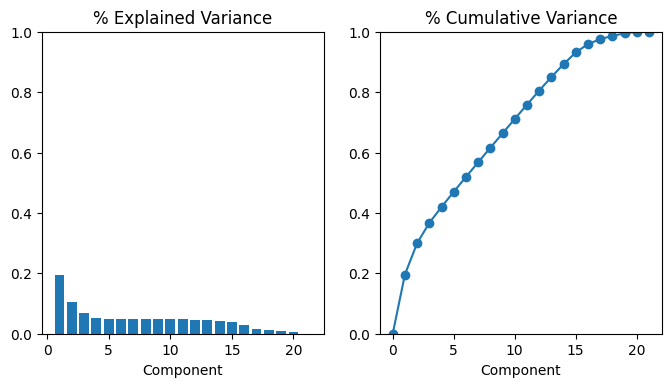

In [ ]:
plot_variance(pca);